# 🧠 Trajectory Reasoning Benchmark: Visual Ordering of Motion Segments

## 🎯 Introduction
In this benchmark, we study the visual reasoning ability of Vision-Language Models (VLMs) through a trajectory sorting task.

Each input consists of a 3D image of a **ball's segmented trajectory**, where each segment is colored differently. The goal is to determine the **temporal order** of these segments — that is, reconstruct the correct sequence of motion based on visual cues.

This task simulates **spatial-temporal reasoning**, such as understanding motion continuity, segment connections, and implicit directional cues.

---

## 🧪 Evaluation Goals

We aim to test whether modern VLMs can:
- Interpret **multi-segment ball trajectories**
- Infer **correct movement order** based on spatial and visual continuity
- Generalize to **in-context and multi-view** conditions

---

## 📐 Evaluation Metrics

We define two metrics for evaluating model predictions:

- ✅ **Exact Match**: The predicted color order must match exactly with the ground truth (order-sensitive).
- 🤖 **LLM Judge (GPT-4)**: An external language model grades the prediction and reasoning on a scale of **1–100**, based on plausibility and logic.

---

## 🧠 Models Evaluated
- `gpt-4o`
- `o3`

---

## 🔬 Ablation Study

We analyze model performance across the following settings:
- **Baseline**: Single-view prediction based only on the visual input
- **In-Context Learning**: A solved example is provided to guide reasoning
- **Multi-View Setting**: The same trajectory is shown from multiple camera angles to improve spatial understanding


# --- Step 1: Collecting Visual Puzzle Data ---

## Setup

In [1]:
# Get the Visual Puzzle Dataset
!git clone --depth=1 https://github.com/ssa-yu/Puzzle_Lab.git

Cloning into 'Puzzle_Lab'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 209 (delta 0), reused 203 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (209/209), 23.56 MiB | 30.61 MiB/s, done.


In [2]:
# Import required library
from google.colab import files
from PIL import Image
import os
import matplotlib.pyplot as plt
import openai
import base64
import json
import textwrap
from collections import defaultdict
import matplotlib.pyplot as plt
openai.api_key = ""  # TODO: Replace with your actual key

## Visualizing Data

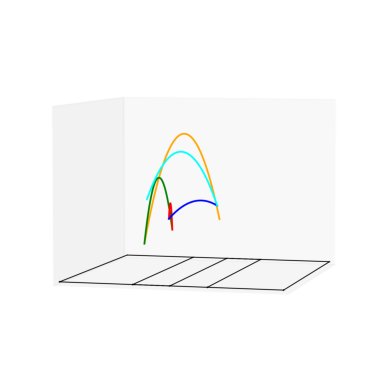



Answer is:  [['orange', 'green', 'red', 'blue', 'cyan'], ['cyan', 'blue', 'red', 'green', 'orange']]


In [7]:
""" This is a starter code to load and display the image """
# First, upload your "drawn" or "found" puzzle image to the folder.

img = Image.open("Puzzle_Lab/dataset/image/2.png")
# Get the answer for a certain image number
def get_answer(number):
  with open("Puzzle_Lab/dataset/answer.json", "r") as f:
    answer_json = json.load(f)
  img_name = f"{number}.png"
  for sample in answer_json:
    if sample["image_id"] == number:
      return sample["color_list"]

# Next, load the image to the colab notebook, and check by visualizing below.
plt.imshow(img)
plt.axis("off")
plt.show()
print("\n\nAnswer is: ", get_answer(2))

## Organizing into Dataset

In [10]:
def get_dataset():
  with open("Puzzle_Lab/dataset/answer.json", "r") as f:
    data = json.load(f)
  datasets = []
  root = "Puzzle_Lab/dataset/image"
  for sample in data:
    img_pth = str(sample["image_id"])+'.'+sample["format"]
    img_view2_pth = str(sample["image_id"])+'_2.'+sample["format"]
    img_pth = os.path.join(root, img_pth)
    img_view2_pth = os.path.join(root, img_view2_pth)
    answer = sample["color_list"]
    datasets.append({"img_path": img_pth, "img_view2_path": img_view2_pth, "gt": answer})
  return datasets
dataset = get_dataset()
# dataset = dataset[:10]
# See 10 examples
# dataset

# --- Step 2: Designing Your Own Metrics ---
Here, You will design your own metrics for the benchmark.

"Metrics" refer to the specific criteria and methods you will use to evaluate the performance of the models on your visual puzzles. This involves defining what constitutes a correct answer and how to measure the degree of correctness.

Below, there is an example of the metric

1. Exact Matching Comparison
2. LLM Judged Matching Comparison

In [3]:
"""
Example 1: Exact Match on 3D trajectory
Compare model output to ground truth answers.
"""
def exact_match(pred, gt):
    return pred in gt

In [4]:
"""
Example 2: Judge with VLM (e.g., GPT-4V)
Ask the model with a judge prompt to figure out if the answer is correct.
"""
def llm_judged_match(pred, gt, reasoning=""):
    pred_str = str(pred)
    gt_str = ", or ".join([str(g) for g in gt])

    prompt = (
        "You are given a ground truth list of possible correct color sequences, and a predicted sequence with its explanation.\n"
        "Evaluate how semantically and logically correct the prediction is based on:\n"
        "1. Whether the prediction matches or closely approximates any of the ground truth sequences (order matters)\n"
        "2. Whether the reasoning justifies the prediction in a logical and coherent way\n\n"
        f"Ground Truth (any of the following are correct): {gt_str}\n"
        f"Prediction: {pred_str}\n"
        f"Reasoning: {reasoning}\n\n"
        "Rate the prediction from 1 to 100, where:\n"
        "- 100 means perfectly correct answer with solid reasoning\n"
        "- 70–90 means mostly correct or reasonable\n"
        "- 50–70 means partially correct but with notable flaws\n"
        "- 30–50 means mostly wrong but shows some effort\n"
        "- 1–30 means completely wrong or illogical\n\n"
        "Respond with only the integer score."
    )

    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a strict but fair grader of visual reasoning tasks."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
            max_tokens=3,  # 最多 3 token 足夠回傳數字
        )

        # 嘗試將回傳值轉為整數
        content = response.choices[0].message.content.strip()
        score = int(content)
        return score

    except Exception as e:
        print("Error during LLM scoring:", e)
        return -1  # 表示失敗


# --- Step 3: Run the VLM on Your Dataset ---
We have a lots of image showing a continuous ball trajectory.

The trajectory is divided into several segments, each marked by a different color, indicating the ball's movement over time.

We hope VLM can analyze the image and return the correct temporal order of these colored segments.

這是一段球類運動的連續軌跡圖像。圖中包含數段以不同顏色標示的軌跡，代表球體在不同時間段的移動情況。請根據這些顏色區分的軌跡，推斷其正確的時間順序，並回答你認為的排序結果。

總共有五種顏色會出現在圖中，分別為：["red", "blue", "green", "orange", "cyan"]

請回傳一個有效的 JSON 物件，包含以下兩個欄位：
1. 'answer'：一個代表正確順序的顏色索引列表，例如：["red", "orange", "blue"]
2. 'reasoning'：你推斷此排序的理由，包括顏色、形狀、空間關係或其他視覺線索


In [16]:
PROMPT = """
This is an image showing a continuous ball trajectory in a sports context. The trajectory is divided into several segments, each marked by a different color, indicating the ball's movement over time.

Please analyze the image and determine the correct temporal order of these colored segments.

There are five possible colors that may appear in the image: ["red", "blue", "green", "orange", "cyan"]

Respond with ONLY a valid JSON object containing two keys without code block:
1. 'answer': a list of color names representing the correct segment order (e.g., ["red", "orange", "blue"])
2. 'reasoning': a detailed explanation of how you determined this order, including any visual cues such as color, motion direction, trajectory shape, or spatial arrangement.
"""


In [17]:
"""
Inference code for the vlm todo
"""
def run_vlm_inference(img_path, model = "gpt-4o"):
    # Encode the image as base64
    with open(img_path, "rb") as image_file:
        base64_img = base64.b64encode(image_file.read()).decode("utf-8")

    # Create the VLM input message
    messages = [
        {"role": "system", "content": "You are a visual inference assistant."},
        {"role": "user", "content": [
            {"type": "text", "text": PROMPT},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_img}"}}
        ]}
    ]

    try:
        # Run GPT-4o
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=messages,
            max_tokens=2048
        )
        content = response.choices[0].message.content.strip()

        # Try parsing the response as JSON
        result = json.loads(content)
        # answer = result.get("answer", "").strip()
        answer = result.get("answer", "")
        reasoning = result.get("reasoning", "").strip()
        return {"answer": answer, "reasoning": reasoning}
    except json.JSONDecodeError:
        print("Model did not return valid JSON.")
        print("Raw output:", content)
        return {"answer": "", "reasoning": ""}
    except Exception as e:
        print("Error during inference:", e)
        return {"answer": "", "reasoning": ""}

In [18]:
# RUN RESULTS ON THE VISUAL PUZZLES and see the results
results = []
for sample in dataset:
    out = run_vlm_inference(sample["img_path"])
    em = exact_match(out["answer"], sample["gt"])
    lj = llm_judged_match(out["answer"], sample["gt"])
    results.append({
        "file": os.path.basename(sample["img_path"]),
        "gt": sample["gt"],
        "pred": out["answer"],
        "exact_match": em,
        "llm_judged": lj
    })

# Show the first 3 results
print("\n--- Sample Results ---")
for r in results[:10]:
    print(f"{r['file']}:")
    print(f"  • GT:        {r['gt']}")
    print(f"  • Prediction:{r['pred']}")
    print(f"    ▶ exact_match = {r['exact_match']}, llm_judged = {r['llm_judged']}\n")

# Then compute overall scores
exact_acc = sum(r["exact_match"] for r in results) / len(results)
llm_acc   = sum(r["llm_judged"] for r in results)   / len(results)
print(f"Exact‐match accuracy: {exact_acc*100:.1f}%")
print(f"LLM judge avg score: {llm_acc}")


--- Sample Results ---
1.png:
  • GT:        [['orange', 'blue'], ['blue', 'orange']]
  • Prediction:['orange', 'blue']
    ▶ exact_match = True, llm_judged = 100

2.png:
  • GT:        [['orange', 'green', 'red', 'blue', 'cyan'], ['cyan', 'blue', 'red', 'green', 'orange']]
  • Prediction:['red', 'green', 'cyan', 'blue', 'orange']
    ▶ exact_match = False, llm_judged = 30

3.png:
  • GT:        [['orange', 'red', 'blue', 'green'], ['green', 'blue', 'red', 'orange']]
  • Prediction:['blue', 'green', 'red', 'orange']
    ▶ exact_match = False, llm_judged = 50

4.png:
  • GT:        [['green', 'blue', 'cyan'], ['cyan', 'blue', 'green']]
  • Prediction:['cyan', 'blue', 'green']
    ▶ exact_match = True, llm_judged = 100

5.png:
  • GT:        [['red', 'cyan'], ['cyan', 'red']]
  • Prediction:['cyan', 'red']
    ▶ exact_match = True, llm_judged = 100

6.png:
  • GT:        [['orange', 'red'], ['red', 'orange']]
  • Prediction:['orange', 'red']
    ▶ exact_match = True, llm_judged = 100

7

#### Check the reasoning

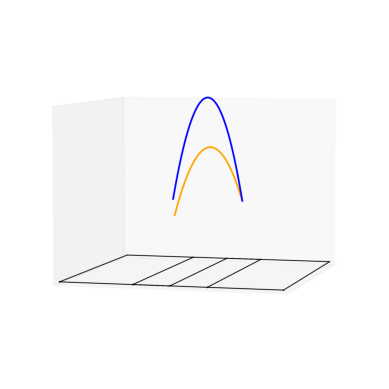

reasoning: 
The ball trajectory starts with the orange segment which forms the ascending part of the parabola,
indicating the ball is moving upwards. The blue segment follows as the descending part of the
parabola, showing the ball is moving downwards. The trajectory is divided into two clear sections,
with the orange segment leading into the blue segment.
Pred: ['orange', 'blue'], GT: [['orange', 'blue'], ['blue', 'orange']]
exact_match: True



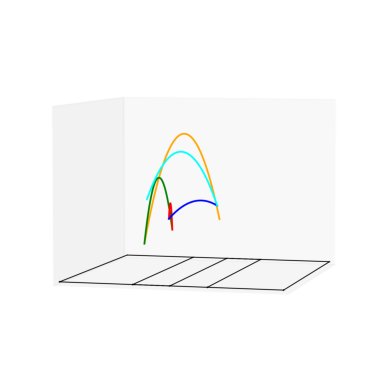

reasoning: 
The trajectory shows a series of arches, indicating a typical ball movement. The red segment is at
the start, closest to the launch point. It transitions to green as the ball ascends further. The
cyan segment marks the peak of the trajectory, followed by the blue segment as the ball descends.
Finally, the orange segment represents the continuation of the descent, moving farthest from the
initial point.
Pred: ['red', 'green', 'cyan', 'blue', 'orange'], GT: [['orange', 'green', 'red', 'blue', 'cyan'], ['cyan', 'blue', 'red', 'green', 'orange']]
exact_match: False



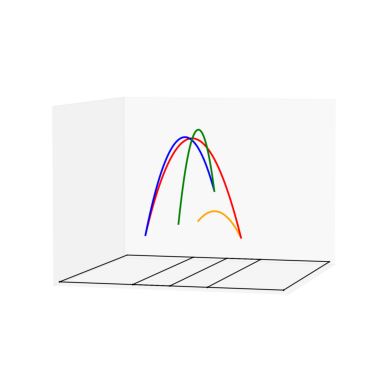

reasoning: 
The image shows a series of arcs representing the ball's trajectory. The blue segment starts on the
left side, marking the beginning of the trajectory. It is followed by the green segment, as
indicated by its continuation of the arc going upward and then slightly right. Next is the red
segment, further right and lower, indicating it's the subsequent part of the descent. Finally, the
orange segment is the smallest and lowest, indicating the last part of the trajectory.
Pred: ['blue', 'green', 'red', 'orange'], GT: [['orange', 'red', 'blue', 'green'], ['green', 'blue', 'red', 'orange']]
exact_match: False



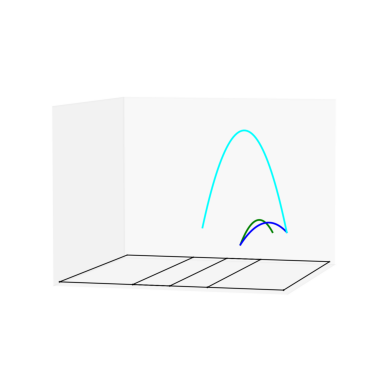

reasoning: 
The trajectory begins with the cyan segment, which is the highest and longest arc, indicating the
initial upward and forward motion of the ball. Following the peak, the green segment continues the
descent, showing a shorter arc. Finally, the blue segment completes the trajectory with the lowest
and shortest arc, suggesting the final part of the ball's motion before it lands.
Pred: ['cyan', 'green', 'blue'], GT: [['green', 'blue', 'cyan'], ['cyan', 'blue', 'green']]
exact_match: False



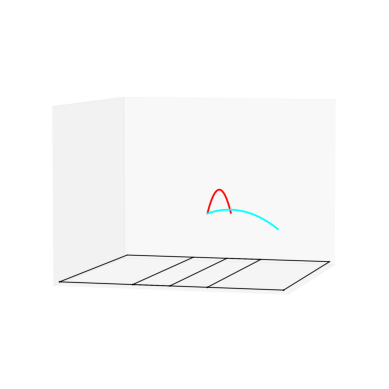

reasoning: 
The trajectory starts with the 'cyan' segment, which begins lower and curves upwards, representing
the initial part of the ball's flight. The 'red' segment continues from a higher point and curves
back downwards, showing the descending motion typical of a projectile. The transition from cyan to
red signifies a complete arc from ascent to descent.
Pred: ['cyan', 'red'], GT: [['red', 'cyan'], ['cyan', 'red']]
exact_match: True



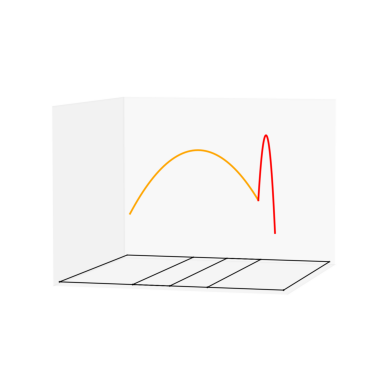

reasoning: 
The image shows two segments of a ball's trajectory represented by two colors: orange and red. The
ball typically follows an arc representing a parabolic path in sports, where it first moves upwards
and then downwards. The orange segment represents the initial upward movement as it follows the
ascending path of the arc. The red segment follows the orange and represents the downward movement,
indicated by its position descending from the peak of the trajectory. Thus, the temporal order is
orange followed by red.
Pred: ['orange', 'red'], GT: [['orange', 'red'], ['red', 'orange']]
exact_match: True



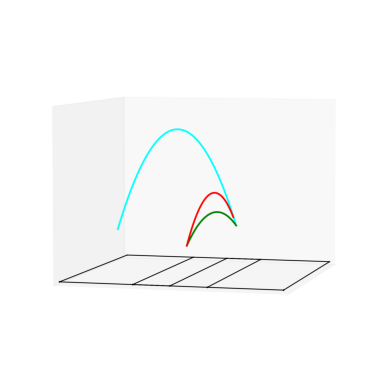

reasoning: 
The image shows the trajectory of a ball divided into three segments, each marked with a different
color: cyan, red, and green. The cyan segment represents the initial path; it starts from a low
point, rises to the highest peak, and descends, indicating the start of the ball's movement. Next,
the red segment follows from where the cyan trajectory ends, peaking at a moderate height compared
to cyan, showing the continuation of the motion as the ball loses energy. Finally, the green segment
continues from the end of the red segment, with the lowest peak, indicating the final part of the
trajectory where the ball lands.
Pred: ['cyan', 'red', 'green'], GT: [['cyan', 'green', 'red'], ['red', 'green', 'cyan']]
exact_match: False



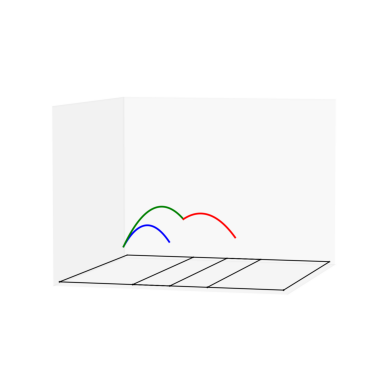

reasoning: 
The image displays a series of arcs representing the ball's trajectory. The segments are color-coded
and represent different stages of the ball's motion. The blue segment, which is the smallest arc,
indicates the starting position of the ball's trajectory. It is closest to the ground and lower than
the others, suggesting the initial phase of movement. Next, the green segment follows, showing a
higher arc as the ball travels further. The final segment is red, depicting the highest and longest
arc as the ball completes its trajectory. The spatial arrangement and height progression of these
arcs inform the temporal order from blue to green to red.
Pred: ['blue', 'green', 'red'], GT: [['blue', 'green', 'red'], ['red', 'green', 'blue']]
exact_match: True



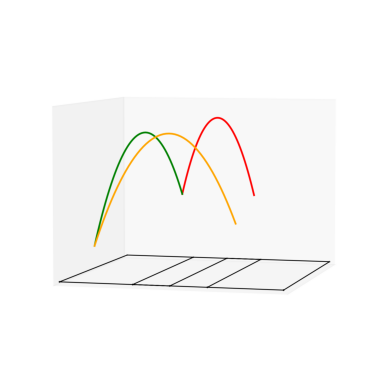

reasoning: 
The trajectory appears to be a series of parabolic arcs. The green segment starts from the left and
follows an upward and then downward curve, indicating it's the first in the sequence. The orange
segment begins where the green segment ends, continuing the motion further to the right. Finally,
the red segment follows the orange segment, completing the sequence. The progression from left to
right is a logical temporal order for these visual elements, with each arc peaking successively
further along the path.
Pred: ['green', 'orange', 'red'], GT: [['red', 'green', 'orange'], ['orange', 'green', 'red']]
exact_match: False



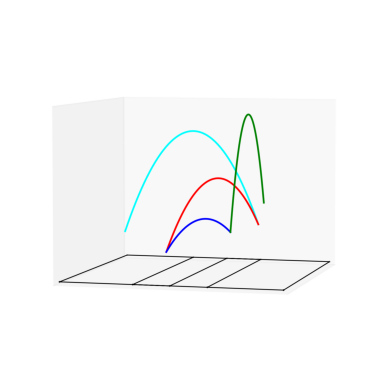

reasoning: 
The image shows a sequence of parabolic arches representing the ball's motion. The trajectory starts
at the lower point, indicated by the cyan segment, which is shown beginning at the furthest point on
the left. Following the natural flow of the arcs and observing the overlaps, the trajectory moves to
the blue segment, characterized by the smaller arc. Next is the red segment, showing a larger arc
overlapping with blue. Finally, the green segment shows the apex of the trajectory, indicating the
highest peak and the final segment.
Pred: ['cyan', 'blue', 'red', 'green'], GT: [['cyan', 'red', 'blue', 'green'], ['green', 'blue', 'red', 'cyan']]
exact_match: False



In [20]:
for sample in dataset[:10]:
    img = Image.open(f"{sample['img_path']}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    out = run_vlm_inference(sample["img_path"])
    em = exact_match(out["answer"], sample["gt"])

    reasoning = textwrap.fill(out['reasoning'], width = 100)
    print(f"reasoning: \n{reasoning}")
    print(f"Pred: {out['answer']}, GT: {sample['gt']}")
    print(f"exact_match: {em}\n")

### Test with model O3

In [28]:
# RUN RESULTS ON THE VISUAL PUZZLES and see the results
o3_results = []
for sample in dataset:
    out = run_vlm_inference(sample["img_path"], model = "o3")
    em = exact_match(out["answer"], sample["gt"])
    lj = llm_judged_match(out["answer"], sample["gt"])
    o3_results.append({
        "file": os.path.basename(sample["img_path"]),
        "gt": sample["gt"],
        "pred": out["answer"],
        "exact_match": em,
        "llm_judged": None,
        "llm_judged": lj
    })

# Show the first 3 results
print("\n--- Sample Results ---")
for r in o3_results[:10]:
    print(f"{r['file']}:")
    print(f"  • GT:        {r['gt']}")
    print(f"  • Prediction:{r['pred']}")
    print(f"    ▶ exact_match = {r['exact_match']}, llm_judged = {r['llm_judged']}\n")

# Then compute overall scores
exact_acc = sum(r["exact_match"] for r in o3_results) / len(o3_results)
llm_acc   = sum(r["llm_judged"] for r in o3_results)   / len(o3_results)
print(f"Exact‐match accuracy: {exact_acc*100:.1f}%")
print(f"LLM‐judged avg score:  {llm_acc}%")


--- Sample Results ---
1.png:
  • GT:        [['orange', 'blue'], ['blue', 'orange']]
  • Prediction:['orange', 'blue']
    ▶ exact_match = True, llm_judged = 100

2.png:
  • GT:        [['orange', 'green', 'red', 'blue', 'cyan'], ['cyan', 'blue', 'red', 'green', 'orange']]
  • Prediction:['red', 'green', 'cyan', 'blue', 'orange']
    ▶ exact_match = False, llm_judged = 50

3.png:
  • GT:        [['orange', 'red', 'blue', 'green'], ['green', 'blue', 'red', 'orange']]
  • Prediction:['blue', 'green', 'red', 'orange']
    ▶ exact_match = False, llm_judged = 70

4.png:
  • GT:        [['green', 'blue', 'cyan'], ['cyan', 'blue', 'green']]
  • Prediction:['cyan', 'green', 'blue']
    ▶ exact_match = False, llm_judged = 30

5.png:
  • GT:        [['red', 'cyan'], ['cyan', 'red']]
  • Prediction:['cyan', 'red']
    ▶ exact_match = True, llm_judged = 100

6.png:
  • GT:        [['orange', 'red'], ['red', 'orange']]
  • Prediction:['orange', 'red']
    ▶ exact_match = True, llm_judged = 100

7

## Benchmark Result

### Model: 4o

*  **Exact‐match accuracy: 39.0%**

*  **LLM judge avg score: 63.2**

### Model: o3

*  **Exact‐match accuracy: 38.0%**

*  **LLM‐judged avg score:  62.41%**

### Analysis

In [26]:
def analyze_accuracy_by_trajectory_count(results):
    count_by_len = defaultdict(int)
    correct_by_len = defaultdict(int)
    score_sum_by_len = defaultdict(int)
    score_count_by_len = defaultdict(int)

    for r in results:
        num_segments = len(r['gt'][0])
        count_by_len[num_segments] += 1
        if r['exact_match']:
            correct_by_len[num_segments] += 1
        if r['llm_judged'] is not None and isinstance(r['llm_judged'], (int, float)):
            score_sum_by_len[num_segments] += r['llm_judged']
            score_count_by_len[num_segments] += 1

    # 準確率與平均 LLM 分數計算
    accuracy_by_len = {}
    llm_score_by_len = {}
    print("Performance by trajectory segment count:")
    for k in sorted(count_by_len):
        acc = correct_by_len[k] / count_by_len[k]
        accuracy_by_len[k] = acc
        if score_count_by_len[k] > 0:
            avg_score = score_sum_by_len[k] / score_count_by_len[k]
            llm_score_by_len[k] = avg_score
        else:
            llm_score_by_len[k] = 0

        print(f"{k} segments: Accuracy = {acc:.2%} ({correct_by_len[k]}/{count_by_len[k]}), "
              f"LLM score avg = {llm_score_by_len[k]:.1f}")

    # 畫雙軸圖
    fig, ax1 = plt.subplots(figsize=(7, 4))

    x = sorted(accuracy_by_len.keys())
    acc_vals = [accuracy_by_len[k] for k in x]
    score_vals = [llm_score_by_len[k] for k in x]

    color1 = 'tab:blue'
    color2 = 'tab:orange'

    ax1.set_xlabel("trajectory segment count")
    ax1.set_ylabel("Exact Match accuracy", color=color1)
    ax1.plot(x, acc_vals, marker='o', color=color1, label="Exact Match")
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylim(0, 1)

    ax2 = ax1.twinx()
    ax2.set_ylabel("LLM Judged Score", color=color2)
    ax2.plot(x, score_vals, marker='s', color=color2, label="LLM Score")
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.set_ylim(0, 100)

    plt.title("VLM Accuracy & LLM Score vs Trajectory Complexity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return accuracy_by_len, llm_score_by_len

## Result
Each 3D trajectory image contains 2 to 5 segments.

I created a chart to see how the number of segments affects the VLM's reasoning performance.


Performance by trajectory segment count:
2 segments: Accuracy = 100.00% (22/22), LLM score avg = 97.7
3 segments: Accuracy = 45.83% (11/24), LLM score avg = 69.6
4 segments: Accuracy = 25.00% (5/20), LLM score avg = 57.5
5 segments: Accuracy = 2.94% (1/34), LLM score avg = 39.7


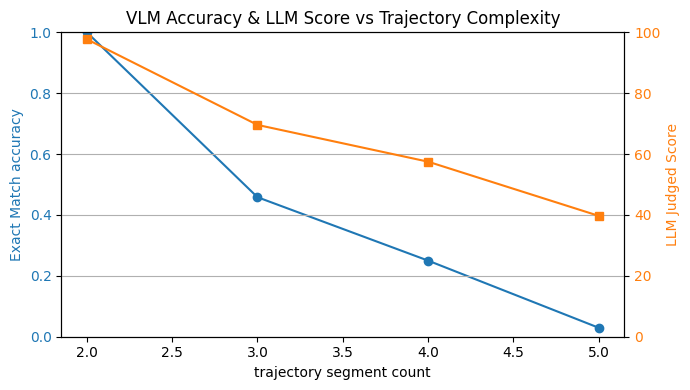

In [27]:
# use gpt-4o
accuracy_by_len, llm_score_by_len = analyze_accuracy_by_trajectory_count(results)

Performance by trajectory segment count:
2 segments: Accuracy = 100.00% (22/22), LLM score avg = 95.5
3 segments: Accuracy = 37.50% (9/24), LLM score avg = 62.9
4 segments: Accuracy = 30.00% (6/20), LLM score avg = 61.0
5 segments: Accuracy = 2.94% (1/34), LLM score avg = 41.5


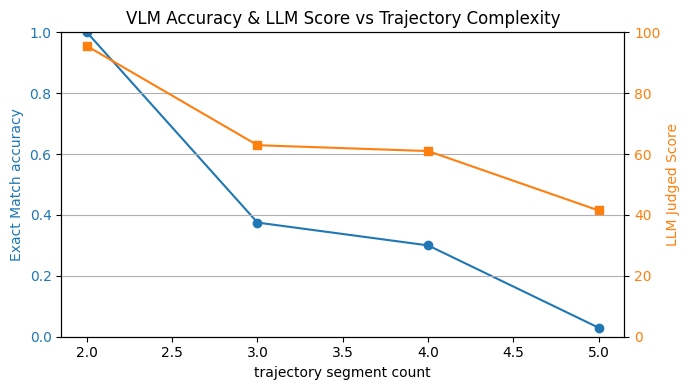

In [29]:
# use o3
accuracy_by_len = analyze_accuracy_by_trajectory_count(o3_results)

# --- Step 4: Implement Ablations ---

### In-context Learning : A solved example is provided to guide reasoning

In [5]:
ICL_PROMPT ="""
You will be given one example, DON'T USE CODE BLOCK!:
<Image>
Response (json):
{
    "answer": ["orange", "red", "blue", "cyan"],
    "reasoning": "The trajectory starts with orange. At the end of the orange segment, it connects directly to the red trajectory. Although the red segment intersects with the cyan trajectory midway, the red segment hasn't ended yet, so cyan is not the next segment. Instead, the red trajectory continues and connects to blue at its end. Finally, the blue trajectory connects to cyan.",
}
"""


In [6]:
PROMPT = """
This is an image showing a continuous ball trajectory in a sports context. The trajectory is divided into several segments, each marked by a different color, indicating the ball's movement over time.

Please analyze the image and determine the correct temporal order of these colored segments.

There are five possible colors that may appear in the image: ["red", "blue", "green", "orange", "cyan"]

Respond with ONLY a valid JSON object containing two keys without code block:
1. 'answer': a list of color names representing the correct segment order (e.g., ["red", "orange", "blue"])
2. 'reasoning': a detailed explanation of how you determined this order, including any visual cues such as color, motion direction, trajectory shape, or spatial arrangement.
"""


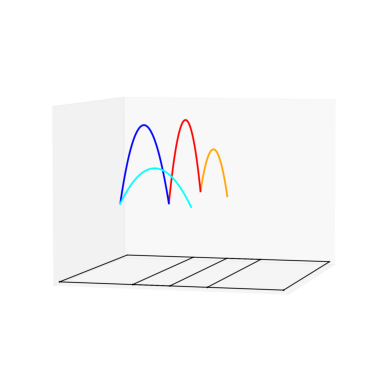

In [7]:
# Vis the ICL image
img = Image.open("Puzzle_Lab/example.png")
plt.imshow(img)
plt.axis("off")
plt.show()

In [8]:
"""
Inference code for the vlm todo
"""
def run_vlm_inference(img_path, model = "gpt-4o"):
    # Encode the image as base64
    with open(img_path, "rb") as image_file:
        base64_img = base64.b64encode(image_file.read()).decode("utf-8")

    ICL_image = "Puzzle_Lab/example.png"
    with open(ICL_image, "rb") as image_file:
        base64_ICL = base64.b64encode(image_file.read()).decode("utf-8")

    messages = [
        {"role": "system", "content": "You are a visual inference assistant."},
        {"role": "user", "content": [
            {"type": "text", "text": ICL_PROMPT},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_ICL}"}},
            {"type": "text", "text": PROMPT},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_img}"}}
        ]}
    ]

    try:
        # Run GPT-4o
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=messages,
            max_tokens=2048
        )
        content = response.choices[0].message.content.strip()

        # Try parsing the response as JSON
        result = json.loads(content)
        # answer = result.get("answer", "").strip()
        answer = result.get("answer", "")
        reasoning = result.get("reasoning", "").strip()
        return {"answer": answer, "reasoning": reasoning}
    except json.JSONDecodeError:
        print("Model did not return valid JSON.")
        print("Raw output:", content)
        return {"answer": "", "reasoning": ""}
    except Exception as e:
        print("Error during inference:", e)
        return {"answer": "", "reasoning": ""}

In [12]:
# RUN RESULTS ON THE VISUAL PUZZLES and see the results
results = []
for sample in dataset:
    out = run_vlm_inference(sample["img_path"])
    em = exact_match(out["answer"], sample["gt"])
    lj = llm_judged_match(out["answer"], sample["gt"])
    results.append({
        "file": os.path.basename(sample["img_path"]),
        "gt": sample["gt"],
        "pred": out["answer"],
        "exact_match": em,
        "llm_judged": lj
    })

# Show the first 3 results
print("\n--- Sample Results ---")
for r in results[:10]:
    print(f"{r['file']}:")
    print(f"  • GT:        {r['gt']}")
    print(f"  • Prediction:{r['pred']}")
    print(f"    ▶ exact_match = {r['exact_match']}, llm_judged = {r['llm_judged']}\n")

# Then compute overall scores
exact_acc = sum(r["exact_match"] for r in results) / len(results)
llm_acc   = sum(r["llm_judged"] for r in results)   / len(results)
print(f"Exact‐match accuracy: {exact_acc*100:.1f}%")
print(f"LLM‐judged accuracy:  {llm_acc}")

Model did not return valid JSON.
Raw output: Response (json):
{
    "answer": ["cyan", "blue", "red"],
    "reasoning": "The trajectory begins with the cyan segment. At the end of the cyan trajectory, it connects to the blue segment. The blue segment continues until it connects with the red trajectory, which is the final segment."
}

--- Sample Results ---
1.png:
  • GT:        [['orange', 'blue'], ['blue', 'orange']]
  • Prediction:['orange', 'blue']
    ▶ exact_match = True, llm_judged = 100

2.png:
  • GT:        [['orange', 'green', 'red', 'blue', 'cyan'], ['cyan', 'blue', 'red', 'green', 'orange']]
  • Prediction:['green', 'red', 'blue', 'cyan', 'orange']
    ▶ exact_match = False, llm_judged = 50

3.png:
  • GT:        [['orange', 'red', 'blue', 'green'], ['green', 'blue', 'red', 'orange']]
  • Prediction:['orange', 'red', 'green', 'blue']
    ▶ exact_match = False, llm_judged = 50

4.png:
  • GT:        [['green', 'blue', 'cyan'], ['cyan', 'blue', 'green']]
  • Prediction:['cyan

#### Test on O3

In [13]:
# RUN RESULTS ON THE VISUAL PUZZLES and see the results
o3_results = []
for sample in dataset:
    out = run_vlm_inference(sample["img_path"], model = "o3")
    em = exact_match(out["answer"], sample["gt"])
    lj = llm_judged_match(out["answer"], sample["gt"])
    o3_results.append({
        "file": os.path.basename(sample["img_path"]),
        "gt": sample["gt"],
        "pred": out["answer"],
        "exact_match": em,
        "llm_judged": lj
    })

# Show the first 3 results
print("\n--- Sample Results ---")
for r in o3_results[:10]:
    print(f"{r['file']}:")
    print(f"  • GT:        {r['gt']}")
    print(f"  • Prediction:{r['pred']}")
    print(f"    ▶ exact_match = {r['exact_match']}, llm_judged = {r['llm_judged']}\n")

# Then compute overall scores
exact_acc = sum(r["exact_match"] for r in o3_results) / len(o3_results)
llm_acc   = sum(r["llm_judged"] for r in o3_results)   / len(o3_results)
print(f"Exact‐match accuracy: {exact_acc*100:.1f}%")
print(f"LLM‐judged accuracy:  {llm_acc}%")

Model did not return valid JSON.
Raw output: Response (json):
{
    "answer": ["cyan", "red", "green"],
    "reasoning": "The trajectory begins with the cyan segment, which is the highest and longest arc. At the end of the cyan segment, it connects directly to the red trajectory. Following the red segment, the trajectory connects smoothly into the green segment. The visual cues such as color order and connection points help determine this sequence."
}
Model did not return valid JSON.
Raw output: Response (json):
{
    "answer": ["blue", "red", "green", "cyan", "orange"],
    "reasoning": "The trajectory begins with the blue segment on the left. The blue segment then connects directly to the red trajectory, following its path. After the red segment concludes, the trajectory connects to the green segment, with no intersections suggesting a detour. From the end of the green segment, it moves directly to cyan. Lastly, the trajectory finishes with the orange segment on the right."
}
Model d

### Result

Performance by trajectory segment count:
2 segments: Accuracy = 100.00% (22/22), LLM score avg = 30.0
3 segments: Accuracy = 37.50% (9/24), LLM score avg = 30.0
4 segments: Accuracy = 45.00% (9/20), LLM score avg = 30.0
5 segments: Accuracy = 2.94% (1/34), LLM score avg = 30.0


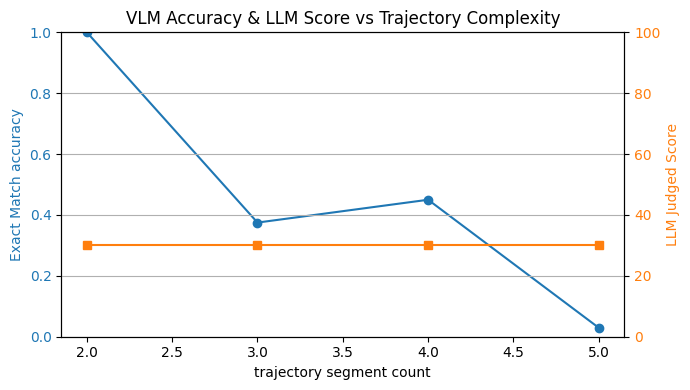

Performance by trajectory segment count:
2 segments: Accuracy = 100.00% (22/22), LLM score avg = 30.0
3 segments: Accuracy = 37.50% (9/24), LLM score avg = 30.0
4 segments: Accuracy = 40.00% (8/20), LLM score avg = 30.0
5 segments: Accuracy = 2.94% (1/34), LLM score avg = 30.0


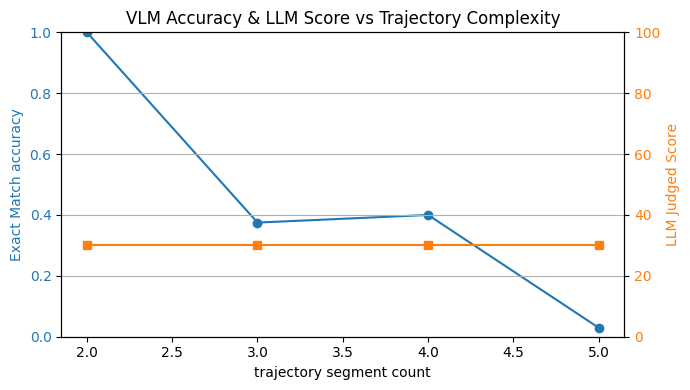

In [49]:
# use gpt-4o
accuracy_by_len, llm_score_by_len = analyze_accuracy_by_trajectory_count(results)
# use o3
accuracy_by_len = analyze_accuracy_by_trajectory_count(o3_results)

### Multi-view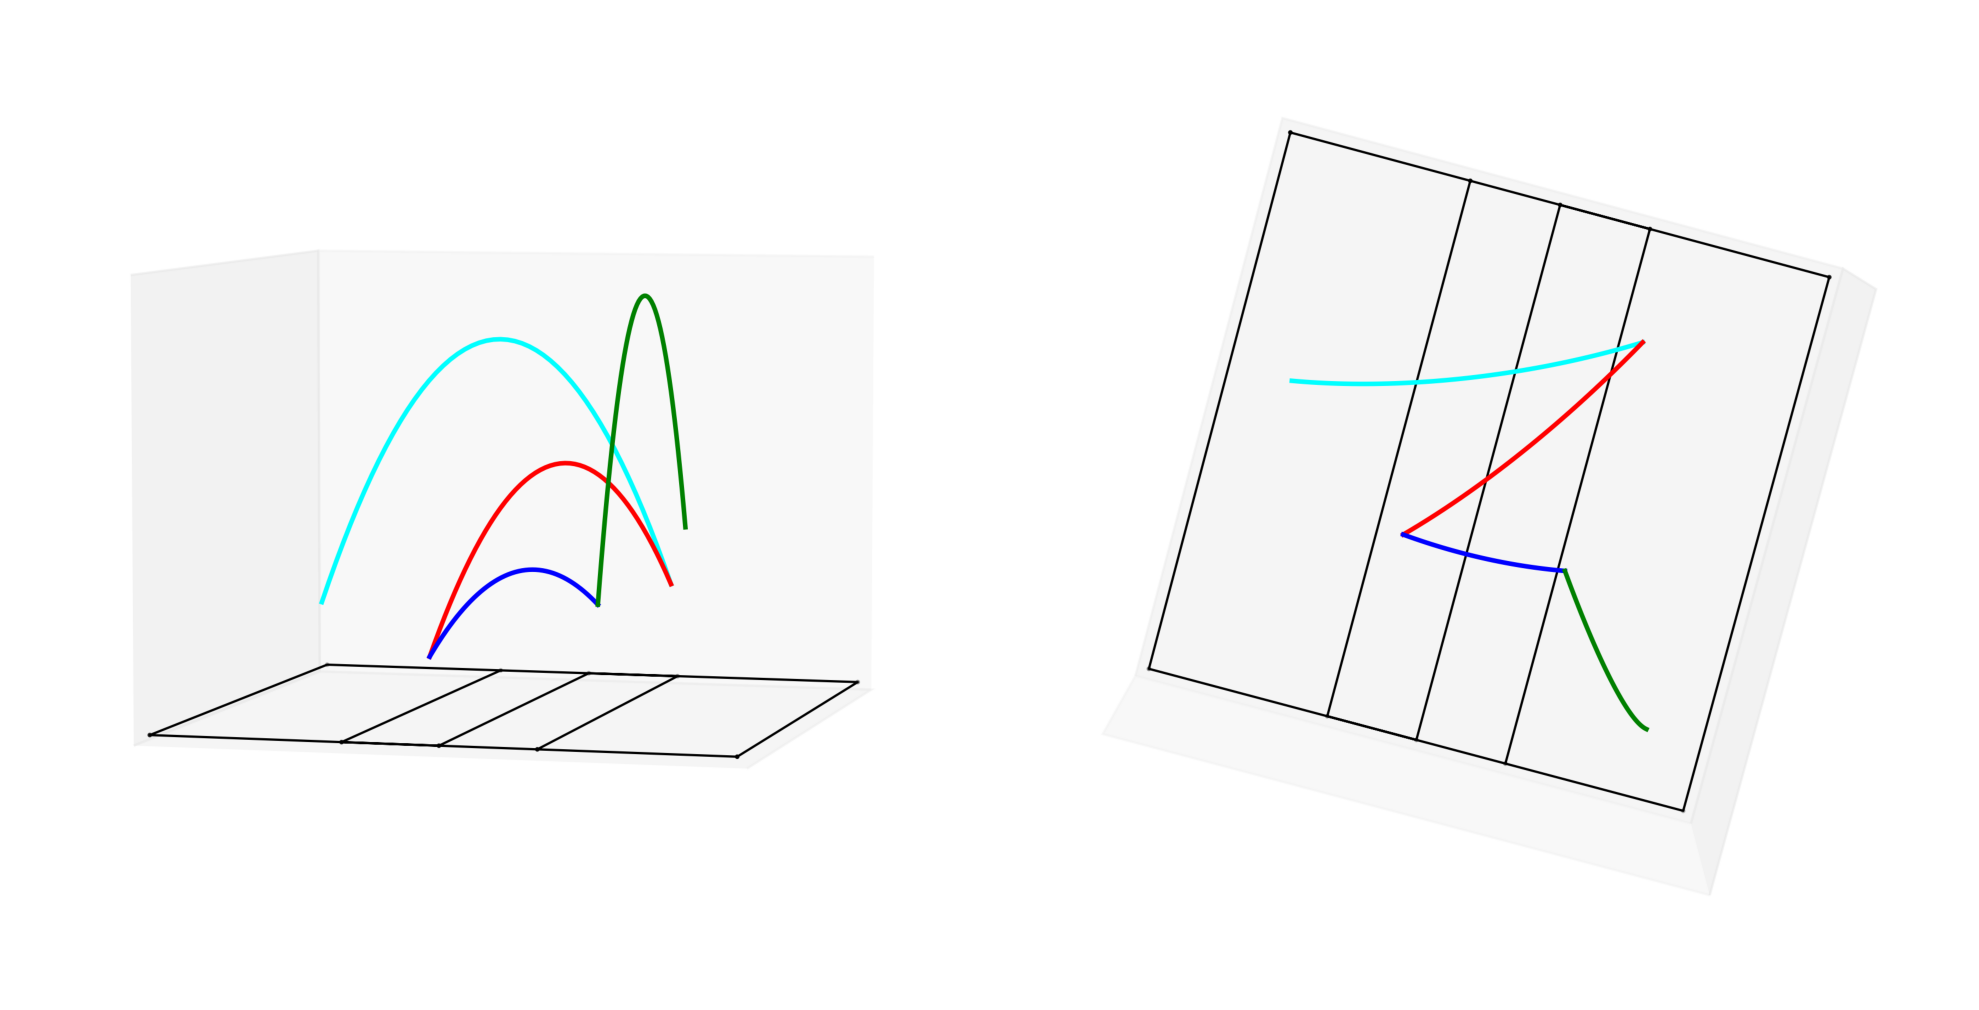

In [50]:
PROMPT = """
You are given multiple images of the same 3D ball trajectory scene. Each trajectory is divided into several segments, and each segment is represented by a distinct color. These segments together form a continuous motion path of the ball over time.

Please carefully analyze all the provided images and determine the correct temporal order of the colored trajectory segments (from earliest to latest). Use all visual clues such as trajectory connections, curvature, spatial continuity, and color position across views.

There are five possible colors that may appear in the image: ["red", "blue", "green", "orange", "cyan"]

Respond with ONLY a valid JSON object containing two keys **without code block formatting**:
1. 'answer': a list of color names representing the correct segment order (e.g., ["orange", "red", "blue", "cyan"])
2. 'reasoning': a detailed explanation of how you determined this order, integrating information from multiple views. Be specific about what you observed in each perspective.
"""


In [51]:
"""
Inference code for the vlm todo
"""
def run_vlm_inference(img_path, img_view2_path, model = "gpt-4o"):
    # Encode the image as base64
    with open(img_path, "rb") as image_file:
        base64_img = base64.b64encode(image_file.read()).decode("utf-8")

    with open(img_view2_path, "rb") as image_file:
        base64_img_view2 = base64.b64encode(image_file.read()).decode("utf-8")

    # Create the VLM input message
    messages = [
        {"role": "system", "content": "You are a visual inference assistant."},
        {"role": "user", "content": [
            {"type": "text", "text": PROMPT},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_img}"}},
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_img_view2}"}}
        ]}
    ]

    try:
        # Run GPT-4o
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=messages,
            max_tokens=2048
        )
        content = response.choices[0].message.content.strip()

        # Try parsing the response as JSON
        result = json.loads(content)
        # answer = result.get("answer", "").strip()
        answer = result.get("answer", "")
        reasoning = result.get("reasoning", "").strip()
        return {"answer": answer, "reasoning": reasoning}
    except json.JSONDecodeError:
        print("Model did not return valid JSON.")
        print("Raw output:", content)
        return {"answer": "", "reasoning": ""}
    except Exception as e:
        print("Error during inference:", e)
        return {"answer": "", "reasoning": ""}

In [52]:
# RUN RESULTS ON THE VISUAL PUZZLES and see the results
results = []
for sample in dataset:
    out = run_vlm_inference(sample["img_path"], sample["img_view2_path"])
    em = exact_match(out["answer"], sample["gt"])
    lj = llm_judged_match(out["answer"], sample["gt"])
    results.append({
        "file": os.path.basename(sample["img_path"]),
        "gt": sample["gt"],
        "pred": out["answer"],
        "exact_match": em,
        "llm_judged": lj
    })

# Show the first 3 results
print("\n--- Sample Results ---")
for r in results[:10]:
    print(f"{r['file']}:")
    print(f"  • GT:        {r['gt']}")
    print(f"  • Prediction:{r['pred']}")
    print(f"    ▶ exact_match = {r['exact_match']}, llm_judged = {r['llm_judged']}\n")

# Then compute overall scores
exact_acc = sum(r["exact_match"] for r in results) / len(results)
llm_acc   = sum(r["llm_judged"] for r in results)   / len(results)
print(f"Exact‐match accuracy: {exact_acc*100:.1f}%")
print(f"LLM judge avg score: {llm_acc}")

Model did not return valid JSON.
Raw output: {'answer': ['green', 'orange', 'blue', 'cyan'], 'reasoning': 'From the first image, the trajectory starts with the green segment, which is on the ground, followed by orange, blue, and finally cyan. The second image, viewed from above, reinforces this order by showing the green segment curving leftward followed by a direct connection to orange. The blue segment follows closely, with cyan showing its continuation.'}
Error during LLM scoring: invalid literal for int() with base 10: ''

--- Sample Results ---
1.png:
  • GT:        [['orange', 'blue'], ['blue', 'orange']]
  • Prediction:['orange', 'blue']
    ▶ exact_match = True, llm_judged = 100

2.png:
  • GT:        [['orange', 'green', 'red', 'blue', 'cyan'], ['cyan', 'blue', 'red', 'green', 'orange']]
  • Prediction:['red', 'green', 'cyan', 'blue', 'orange']
    ▶ exact_match = False, llm_judged = 30

3.png:
  • GT:        [['orange', 'red', 'blue', 'green'], ['green', 'blue', 'red', 'orang

Performance by trajectory segment count:
2 segments: Accuracy = 100.00% (22/22), LLM score avg = 95.4
3 segments: Accuracy = 62.50% (15/24), LLM score avg = 77.9
4 segments: Accuracy = 30.00% (6/20), LLM score avg = 59.5
5 segments: Accuracy = 2.94% (1/34), LLM score avg = 42.1


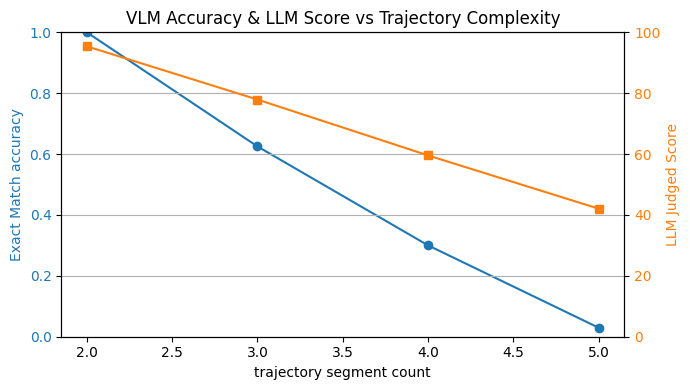

In [53]:
# use gpt-4o
accuracy_by_len, llm_score_by_len = analyze_accuracy_by_trajectory_count(results)
# use o3
# accuracy_by_len = analyze_accuracy_by_trajectory_count(o3_results)

### Ablation Study Result

This experiment shows that using a multi-view approach can further improve the VLM's performance in trajectory reasoning.

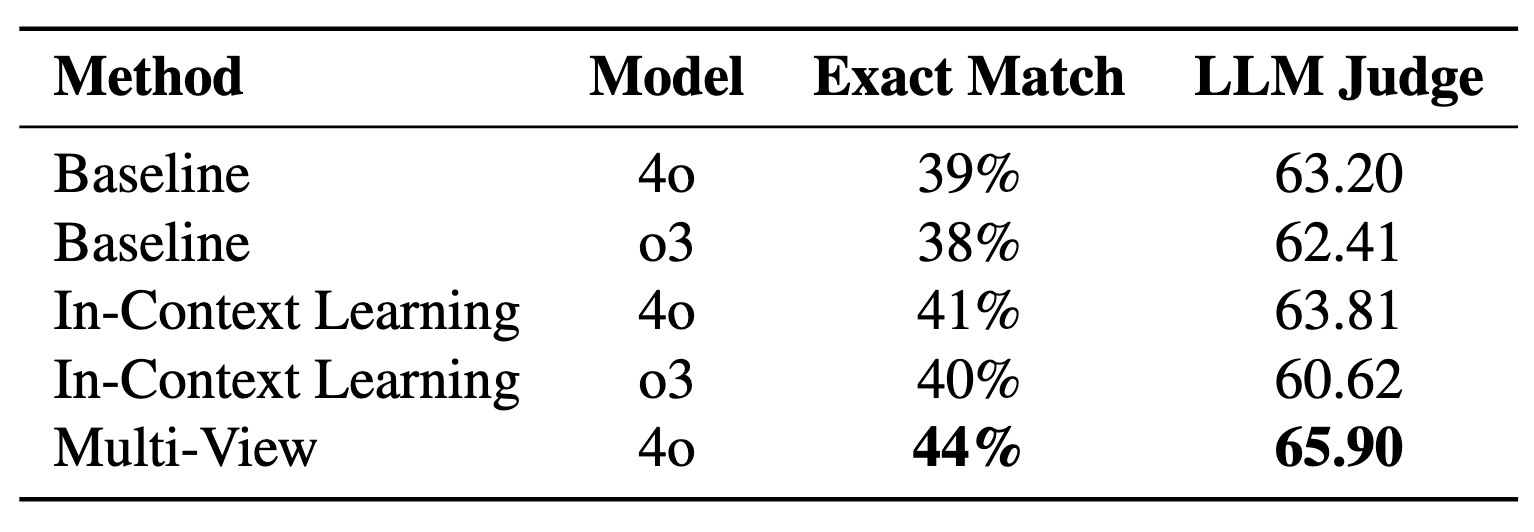